<img src="../assets/cover_image.png" alt="cover" height="600" width="900"/>

<font size="20" color='blue'> Shadow Removal from Document Images using Traditional Approaches</font>

<font size="15" color = 'red'>Monsij Biswal $&$ Swetha Pillai</font>

<font size="10" color = 'red'> ECE-278A Class Project, W22</font>

<font size="15">Shadows - What exactly in numbers ?</font>

<font size="6" color='green'>**Definition**</font>

<font size="5"> Consider a shadow free image $J_c(\mathsf{x})$ and the corresponding input shadow image $I_c(\mathsf{x})$ for $c \in \{R,G,B\}$, where $\mathsf{x}$ and $c$ represent the pixel location and the three color channels respectively.</font>

<font size="5">$$I_c(\mathsf{x}) = S_c(\mathsf{x}) \:.\: J_c(\mathsf{x})$$</font>

<font size="6" color='green'>**Problem Statement**</font>

<font size="5">To estimate the shadow map $S_c(\mathsf{x})$. Note that $S_c(\mathsf{x})$ varies with the pixel location. </font>




<center><img src="../assets/example_op2.png" alt="example" height="600" width="900"/><center>

<font size="15">Shadow Map Estimation
    
<font size="6" color='green'>**Approach #1**</font>

<font size="5">$S_c(\mathsf{x})$ set to the ratio of local and global background colour.</font>
    
<font size="5">$$S_c(\mathsf{x}) = \frac{I_c^{local}(\mathsf{x})}{I_c^{global}(\mathsf{x})}$$</font>
    
<center><img src="../assets/local_global_bg.png" alt="example_bg" height="600" width="900"/><center>

In [1]:
# Imports packages and prepares for execution (PreRUN)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color,filters,transform
from scipy import ndimage as ndi
from helper_functions import *
from tqdm import tqdm


base_img_rpath = '../dataset/document/'  #dataset-read path
base_img_wpath = '../output/document/'   #output-write path

#choices = 'document.png', 'color_mosaic.jpg', 'textbook.jpg', 'manuscript.jpg'

is_0_255 = True   #modifies algo if pixel values are 0-255 (False > color_mosaic), arg passed to functions.


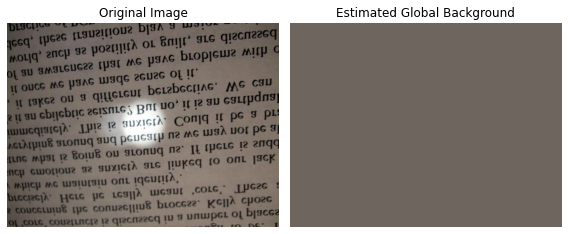

In [2]:
# Extracting global background colour
ip_img = load_img(base_img_rpath + 'textbook.jpg')
choice = 1

if choice==1:
    # Global average over each channel  (Approach #1)  
    I_global = get_global_colour_1(ip_img,is_0_255)
elif choice==2:
    # Max pixel value for each channel  (Approach #2)
    I_global = get_global_colour_2(ip_img,is_0_255)
elif choice==3:
    # Average of top 50 pixels          (Approach #3)
    I_global = get_global_colour_3(ip_img,is_0_255)
f,ax = show_img_compare(ip_img, I_global, 'Original Image', 'Estimated Global Background')

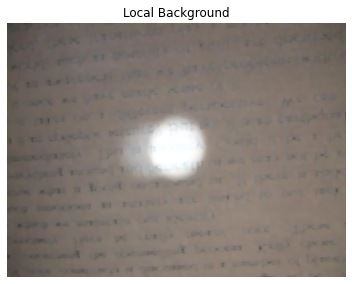

In [3]:
# Estimation of Local Background
p = 0.9
block_size = 7
I_local = get_local_bg(ip_img,p, block_size, is_0_255)
f,ax = plot_img(I_local, "Local Background")

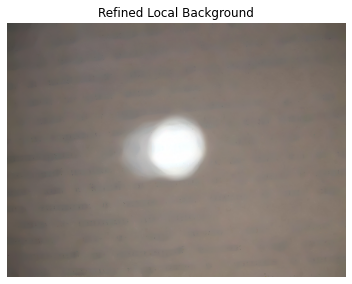

In [4]:
# Refined Estimation of Local Background
threshold = 0.01
median_block_size = 17
I_local_refined = get_local_bg_refined(I_local, ip_img, threshold, median_block_size, is_0_255)
f,ax = plot_img(I_local_refined, "Refined Local Background")

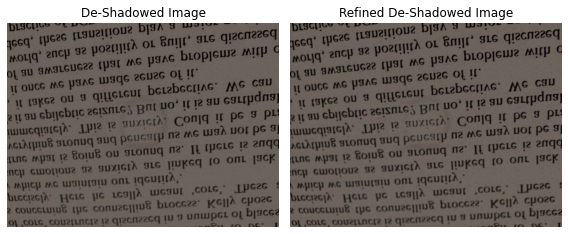

In [5]:
# Deshadowed Image
generate_deshadow(ip_img, I_local, I_global, is_0_255)
I_deshadow = generate_deshadow(ip_img, I_local, I_global, is_0_255)
I_deshadow_refined = generate_deshadow(ip_img, I_local_refined, I_global, is_0_255)

# Plotting 
title1 = 'De-Shadowed Image'
title2 = 'Refined De-Shadowed Image'
f, a = show_img_compare(I_deshadow, I_deshadow_refined, title1, title2)

<font size="5">For a standalone implementation of this approach, please navigate [here](RunMe_approach_1.ipynb).</font>

<font size="15">Shadow Map Estimation
    
<font size="6" color='green'>**Approach #2**</font>
    
<font size="5">- Compute the shadow scale as a ratio of local and global background color</font>
    
<font size="5">- Relight the shadowed regions using the shadow scale</font>    

This exercise aims to remove shadows from text-based images. It comprises of two main steps: shadow detection and shadow removal. We will implement this algorithm as mentioned in the paper to remove shadows while preserving text details.

In [9]:
# import necessary packages
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage.filters import threshold_otsu
from helper_functions import *
from approach2_helpers import *

import warnings
warnings.filterwarnings("ignore")

We start by reading in the image. We convert the image if we want to process it as grayscale. If not, we must process each channel separately and concatenate them.

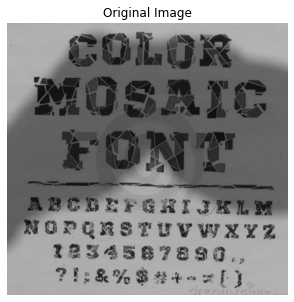

In [10]:
img = read_img('../dataset/document/color_mosaic.jpg', False)

Now we try to get the local background color, which is the image with just the text removed so we can see the outline of the shadow. For this part, the paper discusses a more extensive approach. 

First, we would find the maximum $I_{max}$ and minimum $I_{min}$ within a window across the whole image: 

$$ I_{max}(x, y) = max(I(i, j)), (i,j) \in W $$
$$ I_{min}(x, y) = min(I(i, j)), (i,j) \in W $$

This would then be used to compute a fusion factor $\alpha$ to correct extreme white noise:

$$ \alpha = (I_{max}(x, y) - I_{min}(x, y)) / I_{max}(x, y) $$

The local background color $L$ can be found as a blending operation of the two:

$$ L(x,y) = I_{max}(x, y) * (1-\alpha) +  I_{min}(x, y) * \alpha $$

The paper mentioned that some residual components might persist in the local background image, so to address this, multiple iterations of the mentioned steps is carried out. Apparently, in practice, three iterations using a 5x5 window achieves good results. 

However, this did not produce good results for us. Instead, we simply set the local background color to the results of the maximum filter, shown below. By choosing the window size of the filter appropriately, we can eliminate the text and capture the full area of the shadow.

$$ L(x,y) = I_{max}(x, y) = max(I(i, j)), (i,j) \in W $$

Different images call for different window sizes. After experimenting with this, we can come to the conclusion that the larger or bolder the text in the image, the bigger the window size for the filter. This makes sense -- in order to remove the text, we need a large enough window that captures the text pixels as well as some pixels of the background. The light-colored pixels of the background will dominate over those near-black text pixels.


Find the local background color, the image without text, using a maximum filter.

$$ L(x,y) = I_{max}(x, y) = max(I(i, j)), (i,j) \in W $$

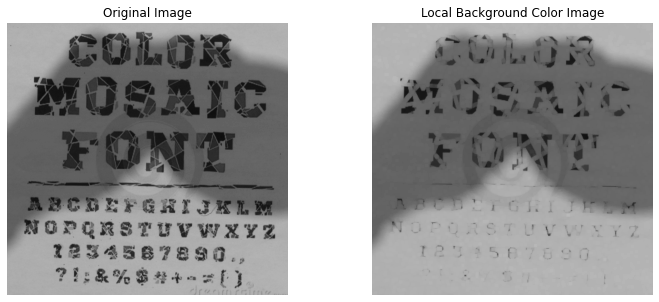

In [11]:
L = get_LocalBG(img, 13)

We can retrieve the shadow map by binarizing the image using threshold OTSU. We can see the local background color image and its shadow map, where the shadowed area is in white and the rest in black.

Use threshold OTSU to binarize the image.

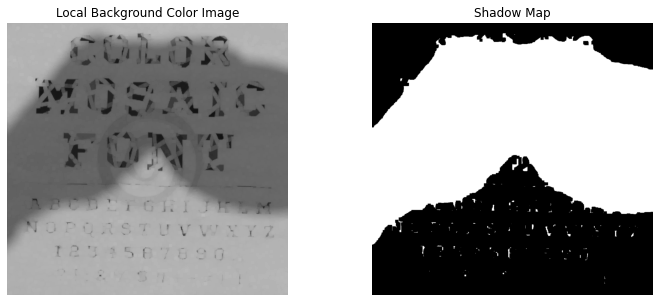

In [12]:
show_ShadowMap(L)

Given the local background color image and shadow map, we can find the global reference background color by finding the average across all pixels within the unshadowed region:

$$ G = \frac{1}{n} \sum L(i, j), (i,j) \in {Unshadowed Region} $$

We can see the unshadowed region and the global background color found from it.

Find the global background color as the average of the unshadowed pixels.

$$ G = \frac{1}{n} \sum L(i, j), (i,j) \in {Unshadowed Region} $$

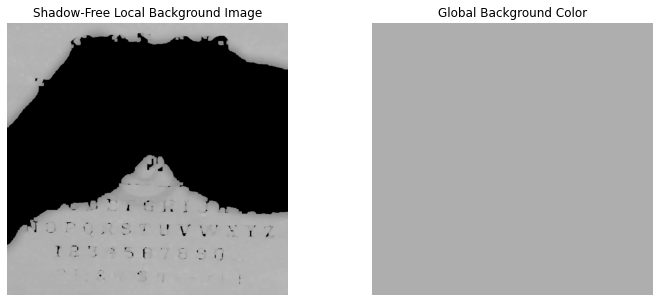

In [13]:
G = get_GlobalBG(L)

Now we can compute the shadow scale $r$ as a function of global background color $G$ and local background color image $L$. The regions obstructed by shadows are generally darker than those without any shadows. We can relight the areas concealed by the shadows by applying the shadow scale. Multiplying the original shadowed image by the shadow scale gives us the final shadow-free image.

$$ r(x,y) = \frac{G}{L(x,y)} $$
$$ final = r(x,y) * img $$

When $r = 1$, it is because $G = L$. $G$ is the color of the unshadowed areas, so the lighter regions. For parts of the image in $L$ where they are shadow-free, $G = L$ and thus $r = 1$. Multiplying the original image by 1 leaves those shadow-free portions unchanged. However, for parts of the image in $L$ that lie within the shadow, $\frac{G}{L}$ will be larger than 1 since the pixels with a lighter color have a higher intensity and pixels with a darker color have a lower intensity. Multiplying the original image by this scalar brightens those shadowed areas to match the color of the global background.

The paper metioned recalculating the local background color $L$ using a 3x3 window but since that did not yield any significant change, we left $L$ as the value which was initially computed.

Compute the shadow scale as a ratio of the local and global background colors.

$$ r(x,y) = \frac{G}{L(x,y)} $$

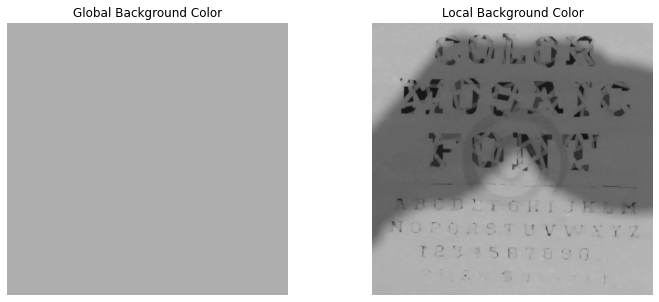

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.axis('off')
ax1.set_title('Global Background Color')
ax1.imshow(G, cmap=plt.cm.gray, vmin=0, vmax=1)
ax2.axis('off')
ax2.set_title('Local Background Color')
ax2.imshow(L, cmap=plt.cm.gray, vmin=0, vmax=1)

Get the shadow-free image by relighting the shadowed regions.

$$ final = r(x,y) * img $$

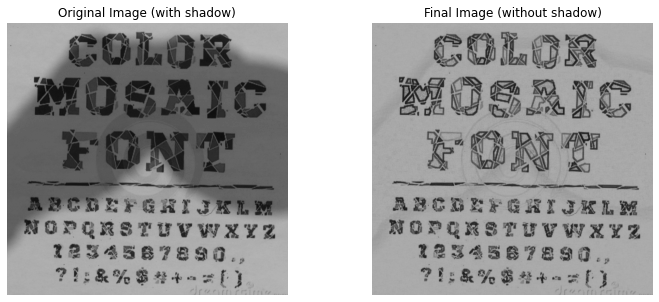

In [15]:
final = get_FinalImg(img, L, G)

When the illumination is non-uniform, we may see some slight artifacts. The paper suggested a method to fix this, called tone fine-tuning. It makes use of a tone scale, which is a ratio between shadowed and unshadowed regions:

$$ \tau = \frac{unshadowed}{shadowed}$$

`unshadowed` is the average background color of unshadowed regions and `shadowed` is the average background color of shadowed regions. Thus, tone scale $\tau$ is a scale between bright and dark regions and applying it on the final image can produce a better removal of shadow.

Fine-tune the image using a tone scale, a ratio of bright to dark regions. 

$$ \tau = \frac{unshadowed}{shadowed}$$

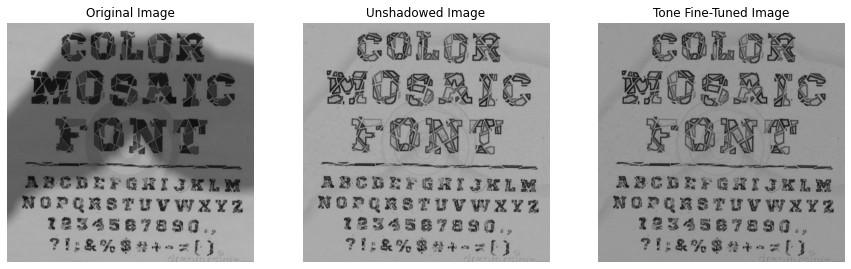

In [16]:
fineTune(img, L, G, final)

As we can see here, the effects of tone fine-tuning are negligible. It was not as helpful for us as the paper mentioned.

The following function is a consolidation of  all the methods listed above.

In [18]:
def removeShadow(filename, isRGB, kernel_size):
  img = read_img(filename, isRGB) # read in image
  L = get_LocalBG(img, kernel_size) # get the local background color
  show_ShadowMap(L) # get the shadow map
  G = get_GlobalBG(L) # get the global background color
  final = get_FinalImg(img, L, G) # show the input vs output
  fineTune(img, L, G, final) # show effects of tuning

Let's run this on some images, both RGB and grayscale. Images include: 'document.png', 'color_mosaic.jpg', 'textbook.jpg', 'manuscript.jpg'

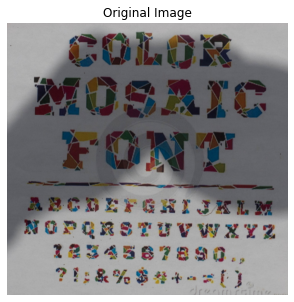

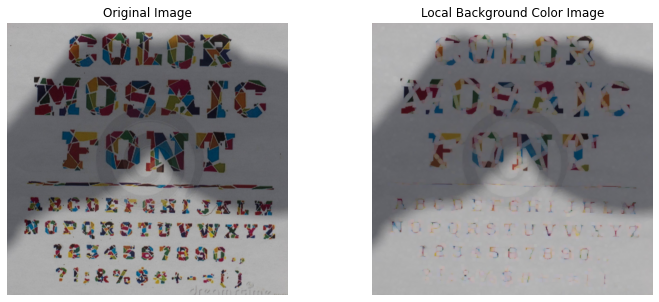

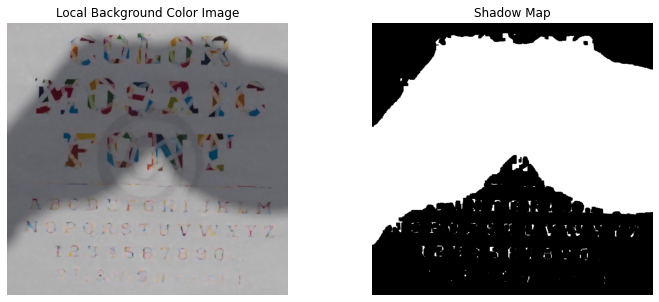

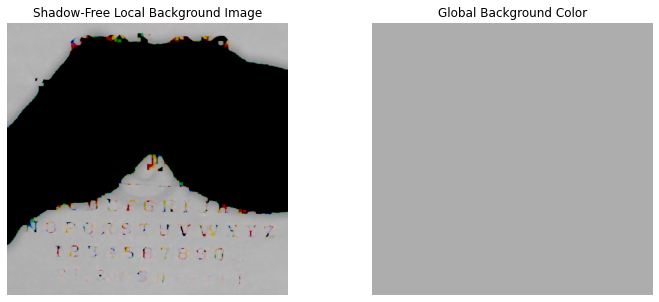

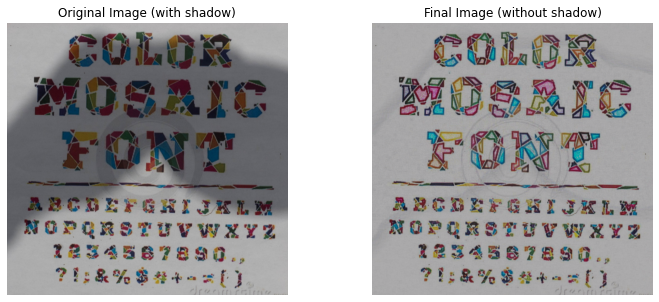

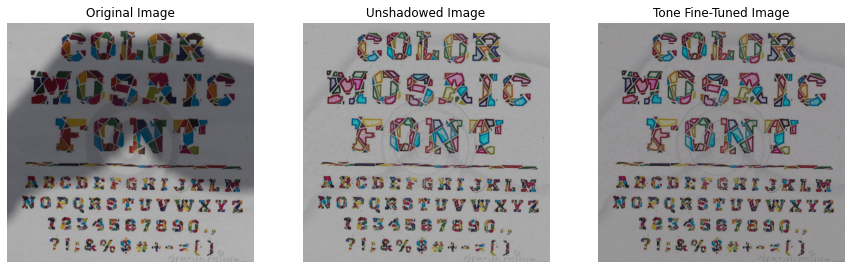

In [19]:
removeShadow('../dataset/document/color_mosaic.jpg', True, 13)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


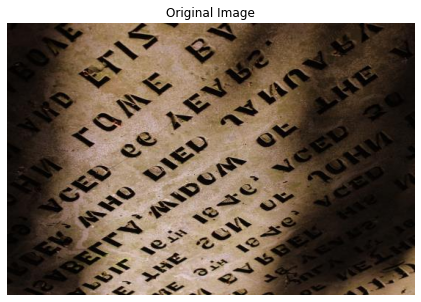

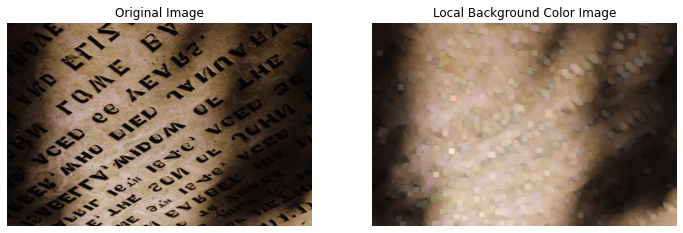

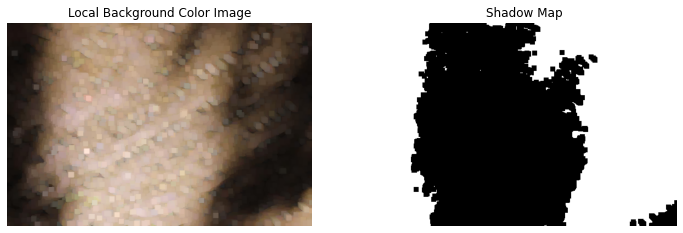

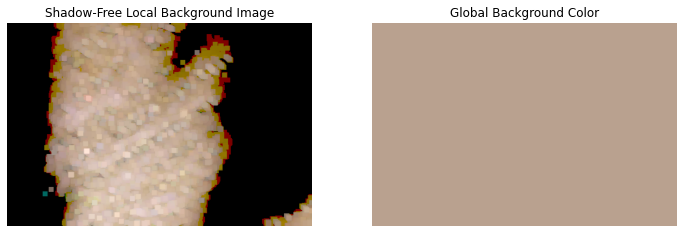

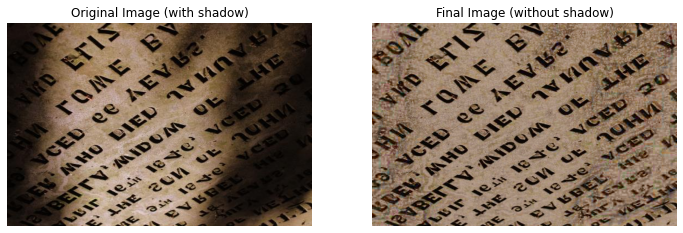

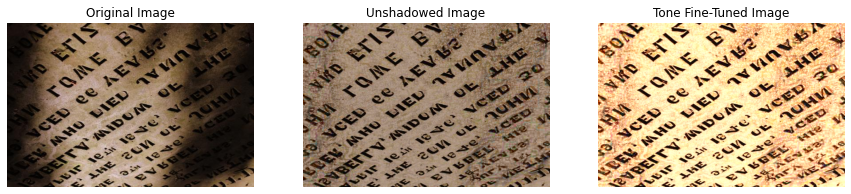

In [20]:
removeShadow('../dataset/document/manuscript.jpg', True, 9)

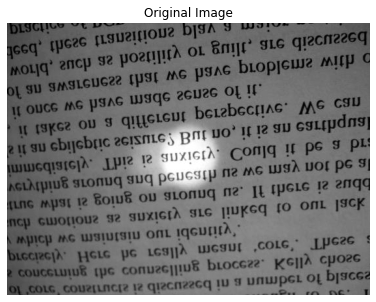

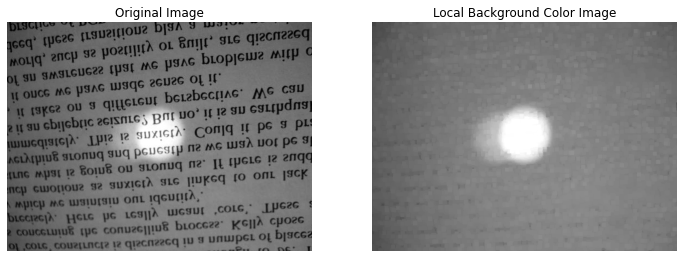

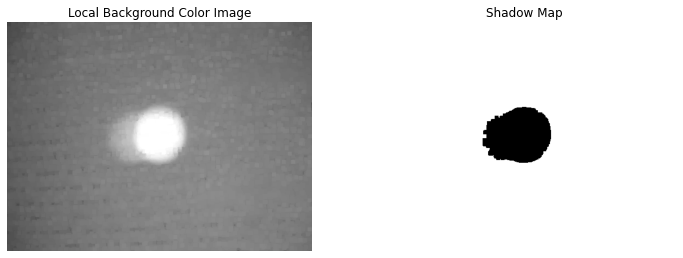

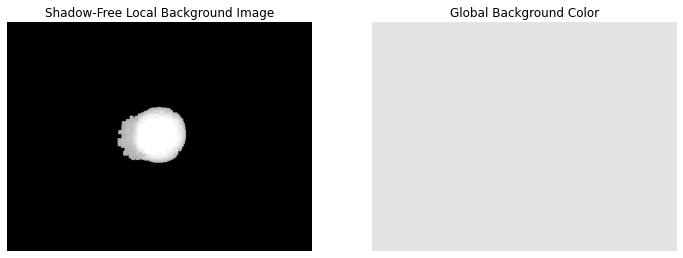

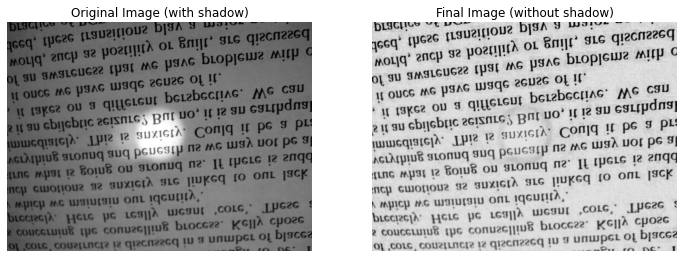

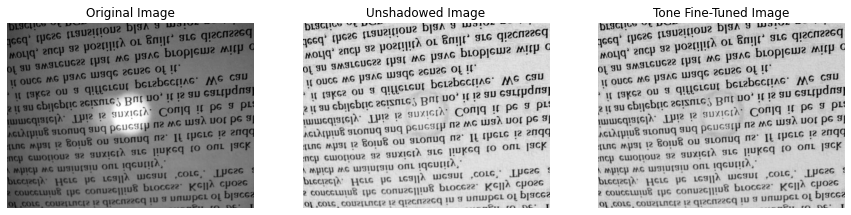

In [21]:
removeShadow('../dataset/document/textbook.jpg', False, 7)

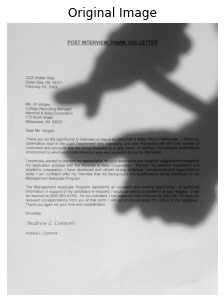

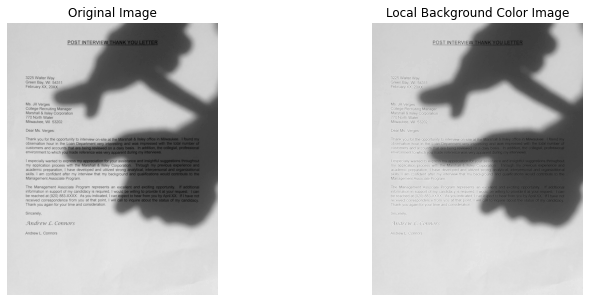

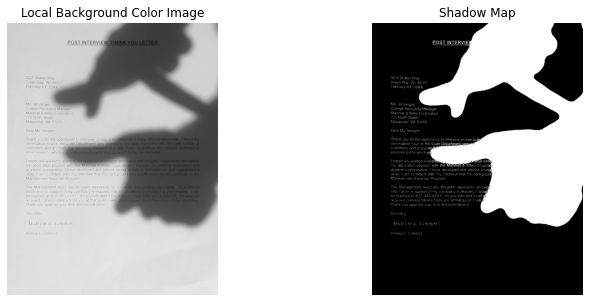

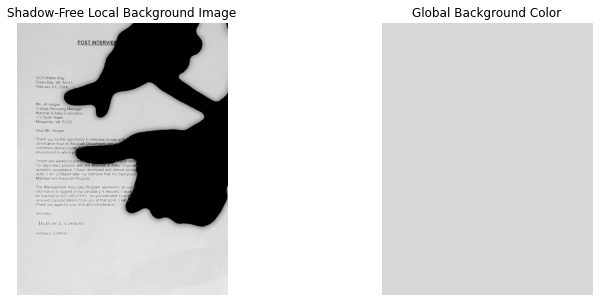

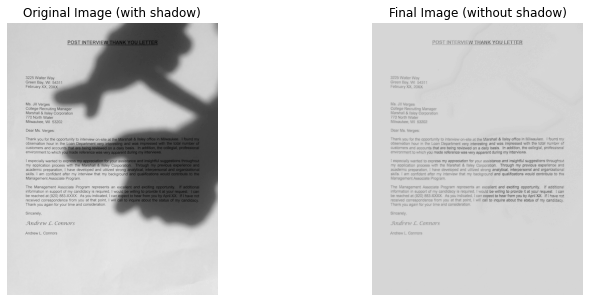

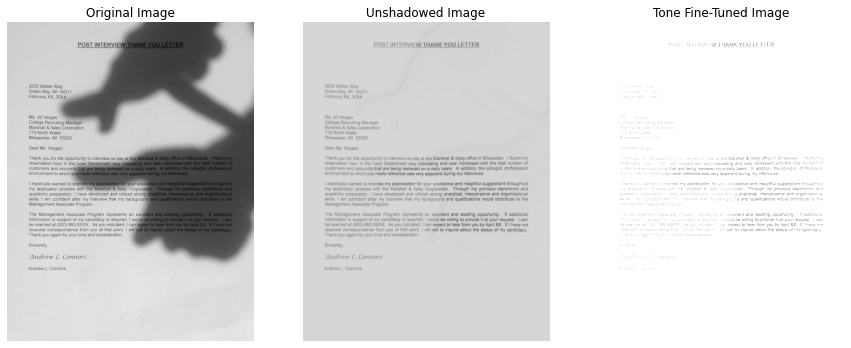

In [22]:
removeShadow('../dataset/document/document.png', False, 2)

This exercise worked to remove shadows from text-based images. To extend this application further, we could apply it to natural images, although this exact approach may not work. Natural scenes contain many more colors, textures, light sources, and other complexities that would require an extensive algorithm.

<font size="5">For a standalone implementation of this approach, please navigate [here](RunMe_approach_2.ipynb).</font>

<font size="15">Shadow Map Estimation
    
<font size="6" color='green'>**Approach #3**</font>
    
<font size="5">1. <u>Binarization</u></font>
    
<font size="5"> Binarizes the input shadow image into foreground and background

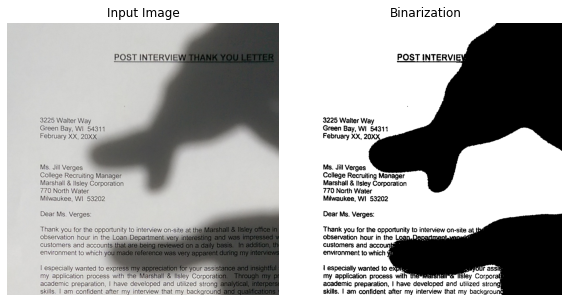

In [3]:
ip_img = load_img(base_img_rpath + 'document.png')
ip_img_gray = color.rgb2gray(ip_img)
threshold_mask = filters.threshold_local(ip_img_gray, block_size=2001)
binary_img = ip_img_gray > threshold_mask
f,ax = show_img_compare(ip_img, binary_img, "Input Image", "Binarization",900,900,img_2_binary=True)

<font size="15">Shadow Map Estimation
    
<font size="5">2. <u>Reflectance and Shading Estimation</u></font>
    
<font size="5">- **Reflectance** : Captures properties of the objects in the image
    
<font size="5">- **Shading** : Accounts for illumination and shading conditions

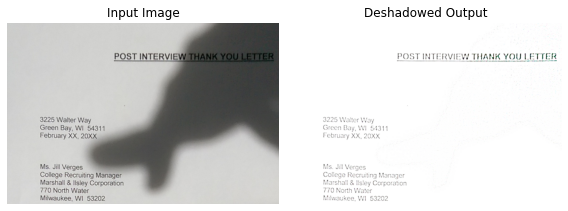

In [4]:
window_size = 15
n_iter = 2
iter_img = ip_img
iter_binary_img = binary_img
for iter in range(n_iter):
    iter_img, iter_binary_img = estimate_shading_reflectance(iter_img, iter_binary_img, window_size)
f,ax = show_img_compare(ip_img,iter_img, "Input Image", "Deshadowed Output",600,900)

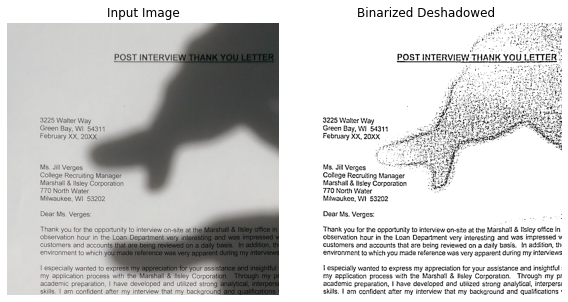

In [5]:
f,ax = show_img_compare(ip_img, iter_binary_img, "Input Image", "Binarized Deshadowed",900,900,img_2_binary=True)

<font size="6" color='green'>**Approach #3**</font>

<font size="5">Additional Example</font>
    
<center><img src="../assets/approach_3_extra.jpeg" alt="example" height="700" width="900"/><center>

<font size="5">For a standalone implementation of this approach, please navigate [here](RunMe_approach_3.ipynb).</font>

<font size="15">Results and Comparison

<center><img src="../assets/comparison.jpeg" alt="example" height="700" width="900"/><center>

<font size="8" color="blue">Contribution Table</font>
<style>
td {
  font-size: 100px
}
</style>

| <font size="6">Task</font>      | <font size="6">Swetha   %</font> | <font size="6">Monsij%</font> |
|---------------|----------------|----------------|
| <font size="5">Approach #1</font>   | <font size="5">10</font>             | <font size="5">90</font>             |
| <font size="5">Approach #2</font>   | <font size="5">80</font>             | <font size="5">20</font>             |
| <font size="5">Approach #3</font>   | <font size="5">10</font>             | <font size="5">90</font>             |
    | <font size="5">Documentation</font> | <font size="5">40</font>             | <font size="5">60</font>             |


<font size="15">References</font>

<font color="blue" size="5">[1]</font> <font size="5">Wang, J.R. and Chuang, Y.Y., 2020, May. Shadow removal of text document images by estimating local and global background colors. In ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1534-1538). IEEE.</font>

<font color="blue" size="5">[2]</font> <font size="5">Wang, B. and Chen, C.P., 2019, September. An effective background estimation method for shadows removal of document images. In 2019 IEEE International Conference on Image Processing (ICIP) (pp. 3611-3615). IEEE.</font>

<font color="blue" size="5">[3]</font> <font size="5">Shah, V. and Gandhi, V., 2018, April. An iterative approach for shadow removal in document images. In 2018 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1892-1896). IEEE.</font>



<font size="15">Questions ?</font>




[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/monsij/Shadow-Removal/HEAD)

![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)